# Netflix Movie Recommendation System

## Overview
This project aims to build a recommendation system for Netflix movies using collaborative filtering and Pearson's R correlations. The dataset used is from the Netflix Prize Data, comprising movie ratings given by users.

## Import Libraries
In this section, essential libraries are imported for data manipulation, visualization, and collaborative filtering.

In [27]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import pandas as pd
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


## Data Loading and Cleaning
* Here, the movie titles dataset is loaded, and a preview of the data is displayed.
* This section involves loading individual movie rating datasets and performing basic cleaning, including handling missing values and converting data types.

In [28]:
# Explore the dataset by loading movie titles
df_title = pd.read_csv('/kaggle/input/netflix-prize-data/movie_titles.csv',encoding = 'ISO-8859-1', on_bad_lines='skip', header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title['Year'] = df_title['Year'].astype('Int64')
df_title.set_index('Movie_Id', inplace = True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW


In [29]:
# Load the 1st data table and clean the NaN
df1 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_1.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df1['Movie_Id'] = df1['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df1['Movie_Id'] = df1['Movie_Id'].ffill()
df1 = df1.dropna()

df1['Movie_Id'] = df1['Movie_Id'].astype('Int64')
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = pd.to_datetime(df1['Date'])

print('Dataset 1 shape: {}'.format(df1.shape))
print('Dataset examples')
display(df1)

Dataset 1 shape: (24053764, 4)
Dataset examples


,Cust_Id,Rating,Date,Movie_Id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [30]:
# 2nd dataset
df2 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_2.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df2['Movie_Id'] = df2['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df2['Movie_Id'] = df2['Movie_Id'].ffill()
df2 = df2.dropna()

df2['Movie_Id'] = df2['Movie_Id'].astype('Int64')
df2['Rating'] = df2['Rating'].astype(float)
df2['Date'] = pd.to_datetime(df2['Date'])
display(df2)

,Cust_Id,Rating,Date,Movie_Id
1,2532865,4.0,2005-07-26,4500
2,573364,3.0,2005-06-20,4500
3,1696725,3.0,2004-02-27,4500
4,1253431,3.0,2004-03-31,4500
5,1265574,2.0,2003-09-01,4500
...,...,...,...,...
26982297,2420260,1.0,2003-12-01,9210
26982298,761176,3.0,2004-06-06,9210
26982299,459277,3.0,2005-02-25,9210
26982300,2407365,4.0,2005-04-29,9210


In [31]:
# 3rd dataset
df3 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_3.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df3['Movie_Id'] = df3['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df3['Movie_Id'] = df3['Movie_Id'].ffill()
df3 = df3.dropna()

df3['Movie_Id'] = df3['Movie_Id'].astype('Int64')
df3['Rating'] = df3['Rating'].astype(float)
df3['Date'] = pd.to_datetime(df3['Date'])
display(df3)

,Cust_Id,Rating,Date,Movie_Id
1,1277134,1.0,2003-12-02,9211
2,2435457,2.0,2005-06-01,9211
3,2338545,3.0,2001-02-17,9211
4,2218269,1.0,2002-12-27,9211
5,441153,4.0,2002-10-11,9211
...,...,...,...,...
22605781,2339129,4.0,2002-10-07,13367
22605782,59005,4.0,2005-01-21,13367
22605783,1789683,5.0,2005-05-25,13367
22605784,1878798,1.0,2003-02-17,13367


In [32]:
# 4th dataset
df4 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_4.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df4['Movie_Id'] = df4['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df4['Movie_Id'] = df4['Movie_Id'].ffill()
df4 = df4.dropna()

df4['Movie_Id'] = df4['Movie_Id'].astype('Int64')
df4['Rating'] = df4['Rating'].astype(float)
df4['Date'] = pd.to_datetime(df4['Date'])
display(df4)

,Cust_Id,Rating,Date,Movie_Id
1,2385003,4.0,2004-07-08,13368
2,659432,3.0,2005-03-16,13368
3,751812,2.0,2002-12-16,13368
4,2625420,2.0,2004-05-25,13368
5,1650301,1.0,2005-08-30,13368
...,...,...,...,...
26851921,1790158,4.0,2005-11-01,17770
26851922,1608708,3.0,2005-07-19,17770
26851923,234275,1.0,2004-08-07,17770
26851924,255278,4.0,2004-05-28,17770


## Exploratory Data Analysis (EDA)
This part explores the distribution of ratings in the dataset using a countplot.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Rating', ylabel='count'>

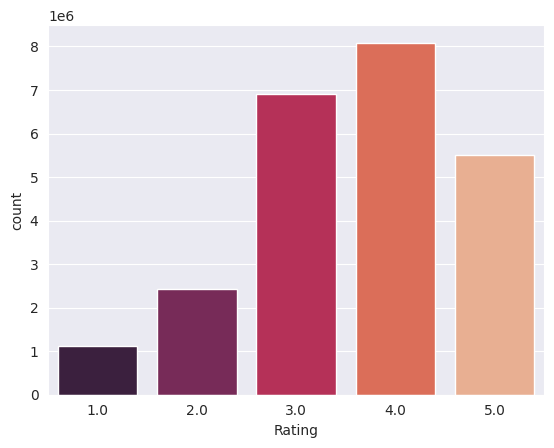

In [33]:
#EDA of the dataset
df = df1
# get movie count
movie_count = df['Movie_Id'].nunique()

# get customer count
cust_count = df['Cust_Id'].nunique() 

# get rating count
rating_count = df['Cust_Id'].count() 
sns.countplot(data = df, x = 'Rating', palette ='rocket')

## Data Reduction
This part reduces the dataset size by trimming less popular movies and less active customers.
The benchmark is set at 70th of the rating. 
We will remove the movie with rating less than the benchmark 

Besides, we will remove the data from user who have few review than the 70th of the review count for each user.

In [37]:
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))


print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
display(df)

Movie minimum times of review: 11472.0
Customer minimum times of review: 133.0
Original Shape: (17337458, 4)
After Trim Shape: (6627885, 4)
-Data Examples-


,Cust_Id,Rating,Date,Movie_Id
52551,1392773,4.0,2004-04-20,28
52553,1990901,5.0,2004-02-16,28
52555,1402412,2.0,2003-02-11,28
52556,765331,3.0,2003-03-20,28
52557,1987434,4.0,2005-07-14,28
...,...,...,...,...
24018713,459277,3.0,2005-09-26,4488
24018716,502274,4.0,2005-10-17,4488
24018719,1055714,5.0,2005-10-26,4488
24018723,1011294,4.0,2005-11-03,4488


## Movie Recomendation - Based on user's experience
This section recommends movies for a specific user (user ID: 1990901) using collaborative filtering SVD.

In [51]:
reader = Reader()
# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.94973991, 0.95824917, 0.95292278, 0.95964753, 0.95588448]),
 'test_mae': array([0.76784473, 0.77519777, 0.77067209, 0.77840811, 0.77078292]),
 'fit_time': (1.476600170135498,
  1.5047721862792969,
  1.528503656387329,
  1.4905223846435547,
  1.502319097518921),
 'test_time': (0.1742384433746338,
  0.18236303329467773,
  0.17563080787658691,
  1.1623175144195557,
  0.1755542755126953)}

In [73]:
# Predict what movie user_765331 would like based on the movie he/she liked in the past (movie that got 5 stars)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df_765331 = df.loc[(df['Cust_Id'] == 765331) & (df['Rating'] ==5)]
display(df_765331)

# Let's predict which movies user_765331 would love to watch:
df_765331 = df_765331.set_index('Movie_Id')
df_765331 = df_765331.join(df_title)['Name']
user_765331 = df_title.copy()
user_765331 = user_765331.reset_index()
user_765331 = user_765331[~user_765331['Movie_Id'].isin(drop_movie_list)]
display(user_765331)

,Cust_Id,Rating,Date,Movie_Id
898464,765331,5.0,2000-05-11,199
1019571,765331,5.0,2001-08-16,241
1473275,765331,5.0,2004-11-30,311
3763240,765331,5.0,2004-08-18,720
4146752,765331,5.0,2001-05-25,798
5981654,765331,5.0,2004-06-01,1180
7075511,765331,5.0,2000-11-02,1425
8090478,765331,5.0,2004-06-24,1625
9249075,765331,5.0,2002-03-19,1832
10165726,765331,5.0,2000-11-02,1974


,Movie_Id,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
...,...,...,...
17429,17766,2002,Where the Wild Things Are and Other Maurice Se...
17430,17767,2004,Fidel Castro: American Experience
17431,17768,2000,Epoch
17432,17769,2003,The Company


In [74]:
# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()
svd.fit(trainset)

user_765331['Estimate_Score'] = user_765331['Movie_Id'].apply(lambda x: svd.predict(765331, x).est)
user_765331 = user_765331.drop('Movie_Id', axis = 1)
user_765331 = user_765331.sort_values('Estimate_Score', ascending=False)
display(user_765331)

,Year,Name,Estimate_Score
857,1954,Seven Samurai,4.704134
1567,1949,The Third Man,4.650324
3253,1941,The Maltese Falcon,4.635677
239,1959,North by Northwest,4.631111
3671,1946,Notorious,4.525328
...,...,...,...
146,2001,Sweet November,1.577889
3599,1992,Encino Man,1.534100
75,1995,Congo,1.528984
2456,2001,America's Sweethearts,1.474273


## Movie Recommendation with Pearson's R Correlations
Here, movie recommendations based on Pearson's R correlations are provided for a specified movie title.

Feel free to explore and experiment with different movie titles and parameters to get personalized recommendations. Enjoy the movie recommendations!

In [128]:
# Create pivot table for machine learning
df['Movie_Id'] = df['Movie_Id'].astype(int)
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
display(df_p)

Movie_Id,28,30,58,77,83,108,111,118,143,148,...,4384,4389,4392,4393,4402,4418,4432,4472,4479,4488
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,3.0,3.0,NaN,NaN
7,4.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,4.0,NaN,NaN,5.0,3.0,5.0,NaN
79,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN
134,5.0,NaN,5.0,4.0,NaN,NaN,NaN,5.0,5.0,5.0,...,4.0,5.0,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN
199,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649067,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,4.0,NaN,5.0,NaN,5.0,4.0,NaN,NaN
2649120,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,5.0,NaN,5.0,NaN,3.0,3.0,5.0,4.0
2649267,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN


In [122]:
# Function using the PearsonR metric to recommend movie
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.loc[df_title['Name'] == movie_title].index[0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))
    

In [129]:
recommend("Spartan", 0)

For movie (Spartan)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                 Name  count     mean
 1.000000              Spartan  14479 3.178258
 0.269063  Surviving Christmas  13327 3.034967
 0.261153          Beauty Shop  13237 3.545894
 0.259653            The Alamo  19016 3.131258
 0.257176        The Final Cut  15295 2.937300
 0.249769          A Man Apart  24010 3.349854
 0.242072       Blade: Trinity  29731 3.533349
 0.237709      The Ladykillers  25200 2.760873
 0.237349 The Bourne Supremacy  85247 3.890154
 0.236437          Man on Fire  77447 3.958630
